In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import glob 

#defining colors
purple = mcolors.to_rgba('#4A1B4F')
pink = mcolors.to_rgba('#CC2A57')
blue = mcolors.to_rgba('#417CBF')
green = mcolors.to_rgba('#23967C')
yellow = mcolors.to_rgba('#D9A433')
grey = mcolors.to_rgba('#595959')
orange = mcolors.to_rgba('#EF5F33')
black = mcolors.to_rgba('#000000')

In [2]:
#function to make the calibration curve
def calcurve(filepath, coordinate, start_marker_cal):
    with open(filepath) as file:
        lines = file.readlines()   
    end_marker_cal = 'Comment' 
    start_index_cal = next((i for i, line in enumerate(lines) if start_marker_cal in line), None)+2
    end_index_cal = (next((i for i, line in enumerate(lines) if end_marker_cal in line), None))-2
    lines_to_skip = list(range(0, start_index_cal)) + list(range(end_index_cal+1, len(lines)))
    calcurve = pd.read_csv(filepath, skiprows=lines_to_skip, header=0, delimiter='\t')
    calcurve = calcurve.drop(['#', 'Weight', 'Error', 'Active','Virtual','Data Name'], axis=1)
    calcurve['log(MW)'] = np.log10(calcurve['M.W.'])
    
    x = calcurve['Time(min)'].values
    y = calcurve['log(MW)'].values

    coeff = np.polyfit(x,y,coordinate)
    poly_function = np.poly1d(coeff)

    x_values = np.linspace(min(x), max(x), 100)
    y_values = poly_function(x_values)

    return poly_function


In [3]:
#this function processes the data to the standards to put apparent MW on the x-axis and normalize the intensity for the y-axis
def process(filepath, csvout,  start_marker, end_marker, coordinate, start_marker_cal, start_time, end_time, blank_filepath):
    poly_function = calcurve(filepath, coordinate, start_marker_cal)
    with open(filepath) as file:
        lines = file.readlines()
    
    #indices for where data being pulled from the text file
    start_index = next((i for i, line in enumerate(lines) if start_marker in line), None)+7
    end_index = (next((i for i, line in enumerate(lines) if end_marker in line), None))-1
    
    #defines which lines to skip so those between are pulled from the text file
    lines_to_skip = list(range(0, start_index)) + list(range(end_index+1, len(lines)))
    
    with open(blank_filepath) as file:
        lines_blank = file.readlines()
    start_index_blank = next((i for i, line in enumerate(lines_blank) if start_marker in line), None)+7
    end_index_blank = (next((i for i, line in enumerate(lines_blank) if end_marker in line), None))-1
    
    #defines which lines to skip so those between are pulled from the text file
    lines_to_skip_blank = list(range(0, start_index_blank)) + list(range(end_index_blank+1, len(lines_blank)))
    
    blank = pd.read_csv(blank_filepath, skiprows=lines_to_skip_blank, header=0, delimiter='\t')
    df = pd.read_csv(filepath, skiprows=lines_to_skip, header=0, delimiter='\t')

    df['Intensity'] -= blank['Intensity'].values
    
    start = df.index[df['R.Time (min)'] == start_time].tolist()[0]
    end = df.index[df['R.Time (min)'] == end_time].tolist()[0]
    rows = range(start, end)
    columns = ['R.Time (min)', 'Intensity']
    data = df.loc[rows, columns]
    
    data['MW_PEG'] = poly_function(data['R.Time (min)'])
    data['MW_PEG'] = 10 ** data['MW_PEG']
    max_intensity = data['Intensity'].max()
    min_intensity = data['Intensity'].min()
    
    data['normalized RI'] = (data['Intensity'] - min_intensity) / (max_intensity - min_intensity)
    data.to_csv(csvout, index=False)
    
    processed = data[['MW_PEG', 'normalized RI']]
    return processed


In [6]:
#this function makes the plot
def plotting(data_to_plot, colors, labels, title, xmin, xmax, plotout, lines, DMF_data, aq_data):
    
    fig = plt.figure()
    for i, df in enumerate(data_to_plot):
        plt.plot(df['MW_PEG'], df['normalized RI'], label=labels[i], color=colors[i], linestyle=lines[i])
                
    plt.xlabel('MW$_P$$_E$$_G$ (Da)')
    plt.ylabel('normalized RI (mV)')
    plt.title(title)
    plt.legend(labels=labels)
    plt.xlim(xmin,xmax)
   
    plt.show()
    fig.savefig(plotout, format='png')


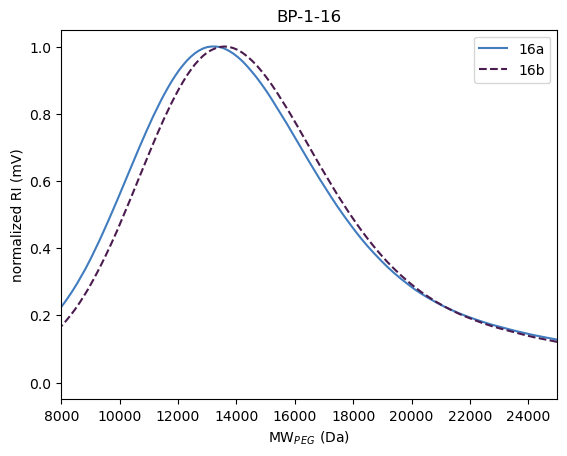

In [12]:
#filepaths for data, you can add as many as you want, just add the necessary filepath, csvout, and blank (if applicable) and be sure to append to data_to_plot
DMF_filepath = 'example_data/example_dmf.txt'
DMF_csvout = 'example_data/example_dmf.csv'
DMF_blank = 'example_data/dmf_blank'
DMF_data = process(DMF_filepath, DMF_csvout, '[LC Chromatogram(Detector A-Ch1)]', '[LC Chromatogram(Detector B-Ch1)]', 5, '[GPC Calibration Curve Table(Detector A)]', 10, 18, DMF_blank)
data_to_plot = [DMF_data]

#uncomment to add another trace; make sure to also append to data_to_plot and add the data to the plotting function call (last line here)
# DMF_filepath2 = '/Users/bridgettepoff/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/Bridgette-notebook1/BP-1-16/GPC/16b_dmf.txt'
# DMF_csvout2 = '/Users/bridgettepoff/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/Bridgette-notebook1/BP-1-16/GPC/16b_dmf.csv'
# # DMF_blank2 = '/Users/bridgettepoff/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/Bridgette-notebook1/BP-1-16/GPC/aq_blank.txt'
# DMF_data2 = process(DMF_filepath2, DMF_csvout2, '[LC Chromatogram(Detector A-Ch1)]', '[LC Chromatogram(Detector B-Ch1)]', 5, '[GPC Calibration Curve Table(Detector A)]', 10, 18, DMF_blank)


# data_to_plot.append(DMF_data2)
colors = [blue, purple]

labels = ['a', 'b']
title = 'title'
xmin = 500
xmax = 25000
plotout = 'example_data/example_dmf.png'
lines = ['-', '--', ':', '-.']

plotting(data_to_plot, colors, labels, title, xmin, xmax, plotout, lines, DMF_data)